# Abstract



# Introduction:

1. Little bit about infections. 

1. how do infection speread by contact. 

1. general compartment models

1. ref a couple of scientific articles on infection spread

1. monte carlo simulations as an alternative to ODE models



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from time import sleep
pick_from = np.random.choice
from os import mkdir 
import pandas as pd

In [2]:
from scipy import integrate

In [3]:
import time

In [4]:
import matplotlib.animation as animation 
from IPython import display

In [5]:
np.random.seed(42) # to get reprodible results

In [6]:
class DiseaseState(Enum):
    '''enumerates disease state of agents'''
    HUMAN = 2
    ZOMBIE = 1
    CURED = 0
    DEAD = 3
    
# extracting name and values of DiseaseState vectors (faster than loops)
def get_name(a):
    return(a.name)
def get_value(a):
    return(a.value)
v_get_name = np.vectorize(get_name)
v_get_value = np.vectorize(get_value)

In [7]:
class SZR():
    '''
    A Suseptible-Zombie-Recovered Random walk model
    '''
    
    #################################################################################################
    ### model setup
    #################################################################################################
    def __init__(self, population=683, infected=1, q=0.9, dp=0 , nx=50, ny=50,**kwarg):
        '''
        Attribute:
            population : population of the a 'isolated' town. 
                         it is assumed no one gets in or out.
            infected   : how many agents are infected at the start of the simulation
            q          : conditional probablility of given contact the porbability of infection spread
            dp         : conditional probablility of given contact the porbability of zombie dies
            nx         : number of spatial grids along x-axis
            ny         : number of spatial grids along y-axis
        '''

        self.q = q 
        self.dp = dp
        self.infected = infected
        self.make_walls(nx, ny)
        self.make_agents(population)
        self.put_in_seed_zombie(infected)
        # self.kill_immunize(1)
        self.make_legal_moves()

        
    def make_walls(self, nx, ny):
        '''
        stores the number of grid points (nx, ny)
        and top(ny-1), bottom(0), left(0), and right(nx-1) wall positions.
        all the 'agents' spawn and move single step up, down, right or left
        '''
        self.nx = nx  # number of x grid points
        self.ny = ny  # number of y grid points
        self.topwall = ny-1
        self.bottomwall = 0
        self.leftwall = 0
        self.rightwall = nx-1
        
    def make_agents(self, population):
        '''
        makes arrays representing a population of size N the 
            id: identifier of the agent, array len=N
            loc : location of the agent on the map  array[N,2]
            infection_status : is the agent infected, len=N 
                               we initiate the whole population as healthy 
                               0 : zombie scum
                               1 : healthy/suspetible
                               2 : cured (she turned me into a newt, 
                                          but i got better)
                               3 : the grateful dead
         '''
        self.population = population
        self.id = np.arange(self.population)

        possible_x_locs = np.arange(self.nx)
        possible_y_locs = np.arange(self.ny)
        self.xlocs = pick_from(possible_x_locs, self.population)
        self.ylocs = pick_from(possible_x_locs, self.population)
        # above we could simply have written
        # xlocs = np.random.choice(self.nx, self.population)
        # but it might be complex to read

        #self.location = np.array([xlocs, ylocs])

        self.infection_status = np.full(self.population, DiseaseState.HUMAN)
        
    def put_in_seed_zombie(self, infected):
        '''
        converts infected number of agents to zombies who can now infect healthy agents
        '''
        # use 'replace = False ' to pick unique agents to infect
        who_is_zombified = pick_from(self.id, infected, replace=False)
        self.infection_status[who_is_zombified] = DiseaseState.ZOMBIE
        # print(self.infection_status)
        
        
    def make_legal_moves(self):
        '''
        initiates helper attributes to move the agents
        creates:
            moves : human readable move keywords
            move_increments : move values in numbers; up =[0,1] etc.
            move_dict ={moves:move_increment}
            we also add an option 'no_move'= [0,0] where agent doesnt move 
        '''
        self.moves = ['up', 'down', 'left', 'right']
        self.moves_increments = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.move_dict = {a: b for a, b in zip(
            self.moves, self.moves_increments)}
        self.move_dict['no_move'] = [0, 0]

    
    def kill_immunize(self, k):
        '''
        for testing: kills one  random agent          
        '''
        who_is_killed = pick_from(self.id, k)
        self.infection_status[who_is_killed] = DiseaseState.DEAD
        who_is_immunized = pick_from(self.id, k)
        self.infection_status[who_is_immunized] = DiseaseState.CURED
    
    ##################################################################################

    #################################################################################################
    ### basic plotting 
    #################################################################################################

    def beautify_grid(self, ax):
        ax.set_xlim([-1, self.nx])
        ax.set_ylim([-1, self.ny])
        ax.grid(linestyle='--', alpha=0.3)
        ax.set_aspect('equal')

    def get_x_y(self, inf_status):
        selected = np.where(self.infection_status == inf_status)
        x = self.xlocs[selected]
        y = self.ylocs[selected]
        return(x, y)

    def plot_locs(self, ax, **kwargs):
        colors = {'HUMAN': 'green', 'ZOMBIE': 'red',
                  'CURED': 'cyan', 'DEAD': 'black'}
        s = {'HUMAN': 5, 'ZOMBIE': 3, 'CURED': 7, 'DEAD': 10}

        color = [colors[i.name] for i in self.infection_status]
        s = [i.value*20+3 for i in self.infection_status]

        # s=
        '''
        for inf_status in [0,1,2]:
            x,y=self.get_x_y(inf_status)
            ax.scatter(x,y,color=c[inf_status],**kwargs)
        '''
        ax.scatter(self.xlocs, self.ylocs, color=color,
                   s=s, alpha=0.5)
        self.beautify_grid(ax)
        
    #################################################################################################
    
    
    #################################################################################################
    ### Class methods to ease calculations 
    #################################################################################################
    
    @classmethod
    def to_tuple(cls, a):
        return ([tuple(i) for i in a])

    @classmethod
    def common_coordinates(cls, a, b):
        '''
        takes two lists of coordinates and returns the coordates that are in common
        as we use set operations each element of the list is converted to a tuple 
        '''
        #nptuple = np.vectorize(tuple)
        a = set(cls.to_tuple(a))
        b = set(cls.to_tuple(b))
        common = a.intersection(b)
        common = [i for i in common]
        return(common)
    
    #################################################################################################
    

    #################################################################################################
    ### Housekeepers: methods to save sim data, turn them into dataframe, get stats from the sim etc
    #################################################################################################

    def save_sim_dat(self):
        folder_name = f'pop{self.population}_infected{self.infected}{np.random.get_state()[1][0]}'
        mkdir(folder_name)
        with open(f'{folder_name}/output.txt', 'w') as f:
            f.write('x locations:\n')
            f.write(repr(pop.sim_xlocs))
            f.write('\ny locations:\n')
            f.write(repr(pop.sim_ylocs))
            f.write('\nmoves:\n')
            f.write(repr(pop.sim_moves))
            f.write('\ninfection status:\n')
            f.write(repr(pop.sim_infection_status))
        print('wrote sim data')

    def show_disease_count(self, t, every=10):
        # prints status every 10th time step
        if every == 0:
            return()

        if t % every == 0:
            s = f'Population count at time step {t:>3}:    '
            for i in DiseaseState:
                s = s+f'{i.name}: {np.sum(self.infection_status==i):>3},   '
            s = s.strip()[:-1]+'.'
            print(s)
        else:
            pass

    def to_DataFrame(self):
        '''Returns a Pandas dataframe of the simulated data'''
        data = {'time': range(self.sim_T+1),
                'xlocs': self.sim_xlocs, 'ylocs': self.sim_ylocs,
                'infection_status': self.sim_infection_status}
        df = pd.DataFrame(data)
        self.sim_df = df
        return(df)

    def get_stats(self, a):
        ds = v_get_name(a)
        counts = []
        for state in self.states:
            counts.append(len(ds[ds == state]))
        return counts

    def get_sim_stats(self):
        '''
        returns a Dataframe containing the number of agents 
        in each disease
        '''
        self.sim_data_df = self.to_DataFrame()
        self.states = [i.name for i in DiseaseState]
        data = self.sim_data_df.infection_status.apply(self.get_stats).tolist()
        self.sim_stats_df = pd.DataFrame(data=data, columns=self.states)
        return self.sim_stats_df
    
    #################################################################################################
    
    
    #################################################################################################
    ### Activities: methods that move the agents, infect them, kill them etc
    ### we can combine them in any order or combination to execute a scenario
    #################################################################################################
    
    def revert_illegal_moves(self, new_xlocs, new_ylocs):
        
        # check for illegal moves
        illegalx = np.where(new_xlocs < self.leftwall)
        new_xlocs[illegalx] = self.leftwall
        illegalx = np.where(new_xlocs > self.rightwall)
        new_xlocs[illegalx] = self.rightwall
        illegaly = np.where(new_ylocs < self.bottomwall)
        new_ylocs[illegaly] = self.bottomwall
        illegaly = np.where(new_ylocs > self.topwall)
        new_ylocs[illegaly] = self.topwall
        
        return(new_xlocs, new_ylocs)
    
    def move_agents(self):
        '''
        moves each agent, alive and zombified one step, up , down, left or right
        the dead agents dont move
        if any of them move outside town they are brought back in 
        '''
        # select random walk for all agents
        steps_ = pick_from(self.moves, self.population)
        # print(self.infection_status,'\n',steps)

        # finds where which agents are dead , set them to no move and keep the other moves
        steps_ = np.where(self.infection_status ==
                          DiseaseState.DEAD, 'no_move', steps_)
        # print(steps)
        # convert steps from strings to move steps
        # and transpose so it can be easily added to xlocs and ylocs
        steps = np.array([self.move_dict[i] for i in steps_]).T
        new_xlocs = steps[0]+self.xlocs
        new_ylocs = steps[1]+self.ylocs
        # print(new_xlocs,self.xlocs)
        # print(new_ylocs,self.ylocs)

        new_xlocs, new_ylocs = self.revert_illegal_moves(new_xlocs, new_ylocs)

        return(new_xlocs, new_ylocs, steps_)
    

    def check_infected_contact(self):
        '''
        checks if zombies comes in contact with a healthy agent
        '''

        #multiple_agent_locs = self.check_where_agents_meets()

        infected_id = np.where(self.infection_status == DiseaseState.ZOMBIE)
        #  infected_locs are where zombies are present
        infected_locs = np.array(
            [self.xlocs[infected_id], self.ylocs[infected_id]]).T
        #print('locations where zombies are present:', infected_locs)

        human_id = np.where(self.infection_status == DiseaseState.HUMAN)
        #  human_locs are where zombies are present
        human_locs = np.array(
            [self.xlocs[human_id], self.ylocs[human_id]]).T
        #print('locations where humans are present:', human_locs)

        # find where both humans and zombies are present
        infection_contact_locs = self.common_coordinates(
            human_locs, infected_locs)
        print('locations where both humans and zombies are present:',
              infection_contact_locs)

        return(infection_contact_locs)
    
    def zombie_death(self):
        '''
        kill zombies randomly at a probability of dp
        '''
        
        zombie_id = np.where(self.infection_status == DiseaseState.ZOMBIE)[0]
        number_of_zombies = len(zombie_id)
        #print('number of zombies', number_of_zombies)
        
        death_happens = np.random.uniform(0,1,number_of_zombies) < self.dp
        #print(death_happens)
        zombies_dead = zombie_id[death_happens]
        self.infection_status[zombies_dead] = DiseaseState.DEAD
        return(self.infection_status)
        

    def spread_infection(self, compounded=False):
        '''
        this is how we spread the disease. 
         1. find where zombies are. [infected locs]
         2. find if there are humans at these locations.
         3. if a location is infected and there are 
            humans (suspetible) present, then try to infected the human
         return 
        at each infection location check if the Human gets infected 
        by the zombies present at the location

        The probability of a healthy human being infected by a zombie, 
        base probablity = q 

        In a compounded scenario, we have assumed that the higher the number of 
        zombies present at a location the higher is the probability of infection.
        So at a location with N zombies present the probability of infecting each
        heathy human is 
        (1 - (1-q)^N)
        '''

        infection_status = self.infection_status.copy()

        # infected_id = bool list, maps to true if Zombie false otherwise.
        infected_id = np.where(infection_status == DiseaseState.ZOMBIE)[0]
        #  infected_locs = location where zombies are present
        infected_locs = np.array(
            [self.xlocs[infected_id], self.ylocs[infected_id]]).T
        #print('locations where zombies are present:', infected_locs)

        human_id = np.where(infection_status == DiseaseState.HUMAN)[0]
        #  human_locs are locations where humans are present
        human_locs = np.array(
            [self.xlocs[human_id], self.ylocs[human_id]]).T
        #print('locations where humans are present:', human_locs)

        # find where both humans and zombies are present
        infection_contact_locs = self.common_coordinates(
            human_locs, infected_locs)
        # print('locations where both humans and zombies are present:',
        #      infection_contact_locs)

        # print(infection_contact_locs)
        #infected_id = infected_id[0]

        for loc in infection_contact_locs:
            # print('-'*80)

            #zombies_here = boolian
            zombies_here = np.where((infected_locs == loc).all(axis=1))[0]
            zombies = infected_id[zombies_here]
            number_of_zombies = len(zombies_here)

            humans_here = np.where((human_locs == loc).all(axis=1))[0]
            humans = human_id[humans_here]
            number_of_humans = len(humans_here)
            #print('old infection status',self.infection_status[humans])

            #spread infection to the humans present at this location
            infection_happens = np.random.rand(number_of_humans) < self.q
            humans_infected = human_id[humans_here[infection_happens]]
            infection_status[humans_infected] = DiseaseState.ZOMBIE
            
            #kill zombies that are present at this location
            #death_happens = np.random.rand(number_of_zombies) < self.dp
            #zombies_dead = infected_id[zombies_here[death_happens]]
            #infection_status[zombies_dead] = DiseaseState.DEAD
            
            
            #print('new infection status',humans_infected,self.infection_status[humans])

            # print(self.infection_status[zombies])
            # print(self.infection_status[humans])
            # print(
            #    f'zombies{infected_id[zombies_here]} are present at loc: {loc}')
            # print(
            #    f'humans{human_id[humans_here]} are present at loc: {loc}')
        # print('='*80)
        return(infection_status)
    
    #############################################################################
    
    
    #############################################################################
    ### Scenarios 
    #############################################################################

    def move_infect_die(self):
        '''
        this is one of the events that  
        '''
        # move agents
        self.xlocs, self.ylocs, steps = self.move_agents()
        # spread infection
        self.infection_status = self.spread_infection()
        #kill zombies
        self.zombie_death()        
        
    #############################################################################
    

    
    #############################################################################
    ### simulation in time domain 
    #############################################################################
    
    def zombie_apocalyps_sim(self, T, every=0, ax=None, write_data=False,**kwarg):
        '''
        Simulates infection spread in T time steps
        every : show number of human and zombies as every number of time step
        write_data: bool, will write file to folder or not
        '''
        # set scenenario:
        self.event_cycle=self.move_infect_die
        
        #store initial condition of the population
        self.sim_T = T
        self.sim_xlocs = [self.xlocs]
        self.sim_ylocs = [self.ylocs]
        self.sim_infection_status = [self.infection_status]
        # print(v_get_value(self.infection_status))
        #self.sim_moves = []

        # print('='*80)
        self.show_disease_count(0, every=every)
        # print('='*80)

        for t in range(T):
            #print('time:', t)
            # self.plot_locs(ax)

            # check which locations can cause the infection to spread
            # for this a healthy agent and an infected agent need to be at
            # the same node
            #infection_locs = self.check_infected_contact()

            #
            self.event_cycle()
            
            # for debugging: shows number of humans, zombies etc 
            self.show_disease_count(t+1, every=every)

            # save simulation state
            self.sim_xlocs.append(self.xlocs)
            self.sim_ylocs.append(self.ylocs)
            #self.sim_moves.append(steps)
            self.sim_infection_status.append(self.infection_status)
            # print(v_get_value(self.infection_status))
            # sleep(1)
        # create dataframe with time wise location and infection status
        self.to_DataFrame()
        # write data to a location if requested
        if write_data:
            self.sim_df.to_csv('sim_data.csv')
        self.get_sim_stats()

In [8]:
def show_Zombieland(sim_data_df, T = None, slowness = 100, skip=1):
    '''
    parameters:
        T = how many days of the simulation to show 
            if set to None, all the whole simulation  will be shown
        skip = how many days to skip between each frame of the animation
               default is 1, that is every single day of the simulation isn shown 
               to show every other day set skip to 2 and so on 
        slowness = pause between each frame in ms
        
    '''
    if T is None:
        T = len(sim_data_df)-1
    interval = slowness
    


    color_dict = {'HUMAN':'g', 'ZOMBIE':'r', 'DEAD':'k', 'CURED':'g' }
    def color_by_status(a):

        c = np.ones_like(a)
        #print(v_get_name(a))
        for i, col in color_dict.items():
            cat = np.where(v_get_name(a)==i)[0]
            c[cat] = col
        return c    


    def get_sim_data(df,t):
        df = df[df.time==t]
        x = df.xlocs.to_numpy()[0]
        y = df.ylocs.to_numpy()[0]
        inf_status = df.infection_status.to_numpy()[0]
        #print(inf_status)
        c = color_by_status(inf_status)
        return(x,y,c)


    # creating a blank window 
    # for the animation 

    fig = plt.figure() 
    axis = plt.axes(xlim =(-1, 50), 
                    ylim =(-1, 50)) 
    t = 0
    axis.set(aspect='equal')
    #tit = axis.set(title=f'Zombie Apocalyps!')

    x,y,c = get_sim_data(sim_data_df, t) 
    #print(len(x), len(y), len(c))
    #print(np.unique(c, return_counts=True))
    dots = axis.scatter(x,y, c=c, s = 10) 
    ttl = axis.text(.45, 1.005, f'Hours since infection start: {0:>3}', transform = axis.transAxes)

    def animate(i): 
        #print(i)
        t = i+1
        x,y,c = get_sim_data(sim_data_df, t) 
        #print(len(x), len(y), len(c))

        #print()
        xy = np.array([x,y]).T
        c = c.T
        #print(xy.shape)
        dots.set_offsets(xy)
        dots.set_facecolor(c) 
        ttl.set_text(f'Days since infection start: {i:>3}')
        return dots,ttl,

    # calling the animation function     
    frames = range(0,T,skip)
    anim = animation.FuncAnimation(fig, animate, 
                                frames = frames,
                                interval = slowness, 
                                blit = True) 

    # if animation doesnt work check  if you have installed ffmpeg
    video = anim.to_html5_video()
    #anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [9]:
#%%capture cap --no-stderr
population = 683
infected = 1
nx = 50
ny = 50
T = 300
pop = SZR(population=population, infected=infected, nx=nx, ny=ny)
pop.zombie_apocalyps_sim(T=T)
sim_data_df = pop.to_DataFrame()


In [10]:
show_Zombieland(sim_data_df,skip=2, slowness=100)

In [11]:
def randomwalk_mc(samples=100, population=683, infected=1, nx=50, ny=50, T=400):
    '''
    Performs monte carlo simulation for the random walk model
    parameters:
    samples: number of simulations to perform
    '''
    mcresults =[]
    for i in range(samples):
        pop = SZR(population=population, infected=infected, nx=nx, ny=ny)
        pop.zombie_apocalyps_sim(T=T)
        sim_stats_df = pop.get_sim_stats()
        sim_stats_df['sim_no']=i
        sim_stats_df['sim_time'] = sim_stats_df.index
        mcresults.append(sim_stats_df)
    return(pd.concat(mcresults))
    

In [12]:
def run_mc(samples = 100,**kwargs):
    mc_results = randomwalk_mc(samples=samples,**kwargs)
    mc_averaged_data = mc_results.groupby('sim_time')[mc_results.columns[:-2]].agg(['mean','std'])
    return mc_averaged_data

In [41]:
def plot_mc_results(ax, mc_averaged_data , cats = ['HUMAN', 'ZOMBIE'],show_band=True):
    
    data = mc_averaged_data[cats]
    t = data.index
    for cat in cats:
        mean = data[cat,'mean']
        std = data[cat,'std']
        ax.plot(t, mean,'--', label = cat+'-RW')
        if show_band:
            ax.fill_between(t,mean+std, mean-std, color = 'grey', alpha = 0.3)
    ax.grid()
    ax.legend()
    return(ax)

## Question 1: 
Assume that there is a single zombie initially, Z(0) = 1, what is
the fate of the zombie and human population? (Figure 4 gives an indication of
what we expect as an answer.)

time taken to run 5 simulations = 1.29s
time taken to run 10 simulations = 2.56s
time taken to run 50 simulations = 12.55s
time taken to run 100 simulations = 25.24s
time taken to run 20 simulations = 5.07s
time taken to run 30 simulations = 7.64s


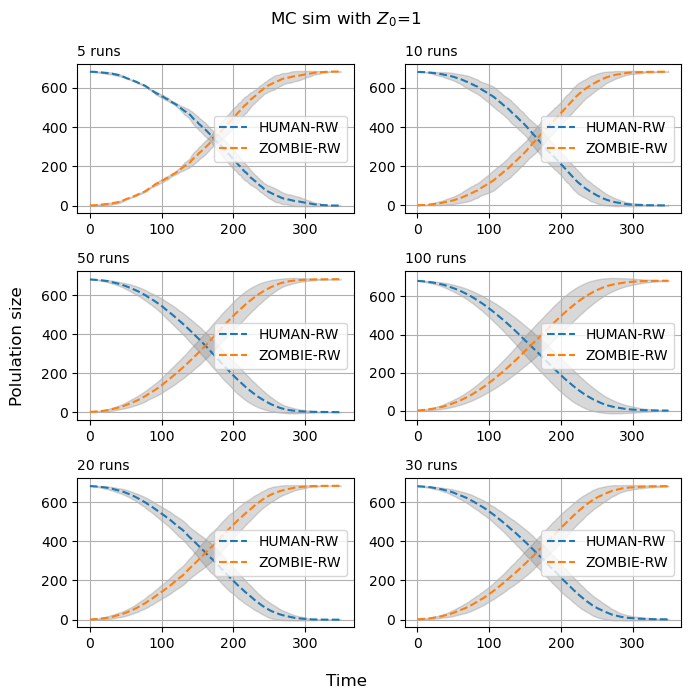

In [14]:
sizes = [5,10,50,100,20,30]
z0,T =1,350
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (7,7))
axs = np.ndarray.flatten(axs)
for size,ax in zip(sizes,axs): 
    a = time.time()
    mc_averaged_data = run_mc(samples=size, infected=z0,T=T)
    plot_mc_results(ax, mc_averaged_data)
    ax.set_title(f'{size} runs', loc ='left', fontsize = 10)
    b = time.time()
    print(f'time taken to run {size} simulations = {b-a:.2f}s')
fig.suptitle(f'MC sim with $Z_0$={z0}')
fig.supxlabel('Time')
fig.supylabel('Polulation size')
plt.tight_layout()

## Question 2: 
If we instead started with Z(0) = 10, how does the time evolution
change?

time taken to run 5 simulations = 0.76s
time taken to run 10 simulations = 1.47s
time taken to run 50 simulations = 7.35s
time taken to run 100 simulations = 14.88s
time taken to run 20 simulations = 2.96s
time taken to run 30 simulations = 4.43s


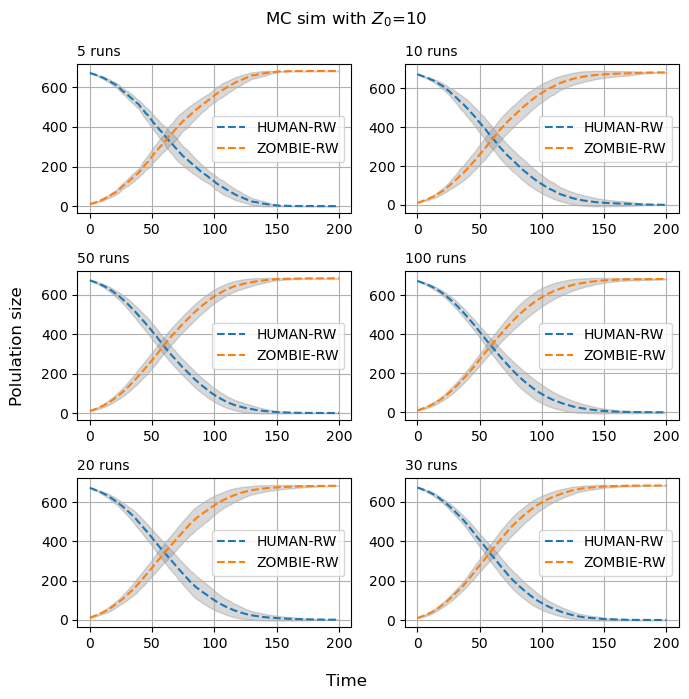

In [15]:
sizes = [5,10,50,100,20,30]
z0,T =10,200
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (7,7))
axs = np.ndarray.flatten(axs)
for size,ax in zip(sizes,axs): 
    a = time.time()
    mc_averaged_data = run_mc(samples=size, infected=z0,T=T)
    plot_mc_results(ax, mc_averaged_data)
    ax.set_title(f'{size} runs', loc ='left', fontsize = 10)
    b = time.time()
    print(f'time taken to run {size} simulations = {b-a:.2f}s')
fig.suptitle(f'MC sim with $Z_0$={z0}')
fig.supxlabel('Time')
fig.supylabel('Polulation size')
plt.tight_layout()

# the code below is still being worked on. IGNORE!!

# Exercise 2: Compare random walk and ODEbased models

In [66]:
class MCRW():
    '''
    provides methods to perfoming monte carlo simulation of the random walk
    '''

    def __init__(self, samples=100, model=SZR):
        self.samples = samples
        self.model = model

    def randomwalk_mc(self, **kwargs):
        '''
        Performs monte carlo simulation for the random walk model
        parameters:
        samples: number of simulations to perform
        kwarg = population=683, infected=1, nx=50, ny=50, T=400
        '''
        mcresults = []
        modelresults = []
        for i in range(self.samples):
            pop = self.model(**kwargs)
            pop.zombie_apocalyps_sim(**kwargs)
            # print(pop.sim_T)

            sim_model_df = pop.to_DataFrame()
            sim_model_df['sim_no'] = i
            #sim_model_df['sim_time'] = sim_model_df.index
            modelresults.append(sim_model_df)

            sim_stats_df = pop.get_sim_stats()
            sim_stats_df['sim_no'] = i
            sim_stats_df['sim_time'] = sim_stats_df.index
            mcresults.append(sim_stats_df)

            # print(sim_data_df)
        self.modelresults_df = pd.concat(modelresults)
        self.mcresults_df = pd.concat(mcresults)
        return(self.mcresults_df)

    def run_mc(self, **kwargs):
        mc_results = self.randomwalk_mc(**kwargs)
        mc_averaged_data = mc_results.groupby(
            'sim_time')[mc_results.columns[:-2]].agg(['mean', 'std'])
        self.averaged_mc_df = mc_averaged_data
        self.modelresults_df = self.add_interactions_column()
        #self.find_beta_tau()
        return mc_averaged_data

    def add_interactions_column(self):
        df = self.modelresults_df
        xlocs, ylocs = df.xlocs.to_numpy(), df.ylocs.to_numpy()
        interactions = []
        for x, y in zip(xlocs, ylocs):
            interactions.append(self.calc_no_of_interactions(x, y))
        interactions = np.array(interactions)
        df['avg_interactions'] = interactions/params['population']
        return df

    def calc_no_of_interactions(self, x, y):
        a = np.array([x, y]).T
        uniques, counts = np.unique(a, return_counts=True, axis=0)
        # print(uniques,counts)

        more_than_one = counts > 1
        counts = counts[more_than_one]
        # if n agents are presnt at a location, number of interactions
        # nc2 =n*(n-1)
        interactions = np.sum(counts*(counts-1))
        return(interactions)

    def find_beta_tau(self):
        df = self.mcresults_df
        betas = []
        taus = []
        for i in range(self.samples):
            _df = df[df.sim_no == i]
            S = _df.HUMAN.to_numpy()
            Z = _df.ZOMBIE.to_numpy()
            D = _df.DEAD.to_numpy()
            N = params['population']
            
            beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
            idx = np.where(1/beta != 0)[0]
            beta = np.nanmean(beta[idx])

            tau = ((D[1:]-D[:-1])/Z[1:])
            idx = np.where(1/tau != 0)[0]
            tau = np.nanmean(tau[idx])

            betas.append(beta)
            taus.append(tau)
            # print(tau)
            # break
        self.avg_beta = -np.mean(betas)
        self.avg_tau = 1/np.mean(taus)

        #print('avg beta ', self.avg_beta)
        #print('avg tau ', self.avg_tau)
        return(self.avg_beta, self.avg_tau)

    def __call__(self, **kwargs):
        pass

\begin{align*}
\frac{dS(t)}{dt}&=-\beta(t)\cdot \frac{S(t)Z(t)}{N}\\
\frac{dZ(t)}{dt}&=\beta(t)\cdot \frac{S(t)Z(t)}{N} - \frac{1}{\tau_{death}\cdot}Z(t)\\
\frac{dR(t)}{dt}&=\frac{1}{\tau_{death}\cdot}Z(t)\\
\end{align*}

In [17]:
class BucketModel():
    '''
    provides solution to continum OED models
    
    \begin{align*}
    \frac{dS(t)}{dt}&=-\beta(t)\cdot \frac{S(t)Z(t)}{N}\\
    \frac{dZ(t)}{dt}&=\beta(t)\cdot \frac{S(t)Z(t)}{N} - \frac{1}{\tau_{death}\cdot}Z(t)\\
    \frac{dD(t)}{dt}&=\frac{1}{\tau_{death}\cdot}Z(t)\\
    \end{align*}
    
    population is split into Susseptible(S), Zombies(S), Dead or Debrained (D)
    infection rate is β(t). Death/Decaptation rate is τ_death
    '''
    def __init__(self,N=683, Z0=10,D0=0,T=200, beta=0.9, tau=np.inf, size = 100):
        '''
        params
        N: total population
        Z0: number of zombies at t=0
        T : time for which sim runs (unit agnostic, so keep units consistent)
        size : 1/dt 
        beta: infection rate, conditional probability that an encounter will result in a 
        pd: probability that a zombie human interaction ends in the death of a zombie
        '''
        self.N=N
        self.Z0=Z0
        self.D0=D0
        self.S0=self.N-self.Z0-self.D0
        self.beta=beta
        self.tau = tau
        self.t = np.linspace(0,T,size+1)
        
    #@classmethod
    def ODE_analytical(self):
        '''
        provides the analytical solution to the OED model.
        \tau and 
        '''
        #S0 = N-Z0
        Zt = self.N/(1+self.S0/self.Z0*np.exp(-self.beta*self.t))
        return(self.t,self.N-Zt,Zt)

    #@classmethod
    def ODE_SZ_model(self):
        '''
        Provides the solution from integration of equations
        '''
        
        def rhs(X, t):
            S, Z, R = X
            
            return [-beta*S*Z/N, +beta*S*Z/N - Z/tau, +Z/tau]

        #X0 = np.array([N-Z0-R0, Z0, R0])
        N=self.N
        beta=self.beta
        tau=self.tau
        X0 = [self.S0, self.Z0, self.D0]
        sol = integrate.odeint(rhs, X0, self.t)
        return self.t, sol


In [19]:
params = {'population':683, 'infected':10, 'q':0.9, 'nx':50, 'ny':50, 'T':180}
samples = 100
mcmodel=MCRW(samples=samples)
_ = mcmodel.run_mc(**params)
mcmodel
mcmodel.find_beta_tau()
beta = mcmodel.avg_beta
a = BucketModel(beta=beta, size = 200)
t_ana,S_ana,Z_ana = a.ODE_analytical()
t_ode,soln = a.ODE_SZ_model()
S_ode, Z_ode = soln[:,0],soln[:,1]

avg beta  0.07005772674332014
avg tau  inf


/tmp/ipykernel_1803/2462725121.py:82: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/beta != 0)[0]
/tmp/ipykernel_1803/2462725121.py:86: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/tau != 0)[0]
/tmp/ipykernel_1803/2462725121.py:81: RuntimeWarning: divide by zero encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_1803/2462725121.py:81: RuntimeWarning: invalid value encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_1803/2462725121.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  self.avg_tau = 1/np.mean(taus)


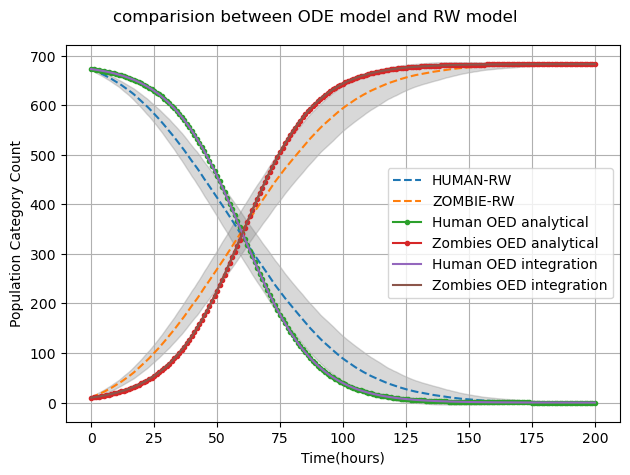

In [20]:
fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df)
ax.plot(t_ana, S_ana,'.-', label='Human OED analytical')
ax.plot(t_ana, Z_ana,'.-', label='Zombies OED analytical')

ax.plot(t_ode, S_ode,'-', label='Human OED integration')
ax.plot(t_ode, Z_ode,'-', label='Zombies OED integration')

ax.legend()
fig.suptitle('comparision between ODE model and RW model')
ax.set(xlabel='Time(hours)', ylabel='Population Category Count')
plt.tight_layout()

The match between the analytical ODE model and Random walk model is good. possible explanations fro deviation:
1. ODE assumption that the population is well mixed causes the disease to spread much quicker. 
We can try to find the p( conditional probability that a given contact is between a susceptible and infected individual) and run the model model again to check the differnce.


# Exercise 3: Scenario what happens in Sokndal and Dirdal?+
# Exercise 4: Compare your results with SZR model

In [21]:
# Dirdal
#
place = 'Dirdal'
zomb_life_exp = 48
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':700}
samples = 100 # increase samples for final submission
mcmodel=MCRW(samples=samples)
_ = mcmodel.run_mc(**params)

avg beta  0.09768575721758978
avg tau  45.41455867627233


/tmp/ipykernel_1803/2462725121.py:81: RuntimeWarning: invalid value encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_1803/2462725121.py:82: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/beta != 0)[0]
/tmp/ipykernel_1803/2462725121.py:85: RuntimeWarning: divide by zero encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_1803/2462725121.py:85: RuntimeWarning: invalid value encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_1803/2462725121.py:86: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/tau != 0)[0]


In [22]:
mcmodel.find_beta_tau()
beta = mcmodel.avg_beta
tau = mcmodel.avg_tau
a = BucketModel(beta=beta,tau=tau, T=700, size = 700)
#t_ana,S_ana,Z_ana = a.ODE_analytical()
t_ode,soln = a.ODE_SZ_model()
S_ode, Z_ode,D_ode = soln[:,0],soln[:,1], soln[:,2]

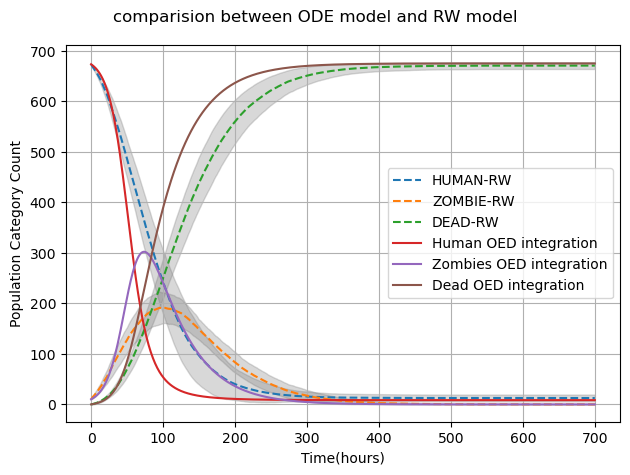

In [23]:
fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df, cats=['HUMAN', 'ZOMBIE', 'DEAD'])

ax.plot(t_ode, S_ode,'-', label='Human OED integration')
ax.plot(t_ode, Z_ode,'-', label='Zombies OED integration')
ax.plot(t_ode, D_ode,'-', label='Dead OED integration')


ax.legend()
fig.suptitle('comparision between ODE model and RW model')
ax.set(xlabel='Time(hours)', ylabel='Population Category Count')
plt.tight_layout()

In [24]:
# Sokndal
#
place = 'Sokndal'
zomb_life_exp = 24
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':700}
samples = 100
mcmodel=MCRW(samples=samples)
_ = mcmodel.run_mc(**params)

avg beta  0.07023560881356486
avg tau  21.145203010584694


/tmp/ipykernel_1803/2462725121.py:81: RuntimeWarning: invalid value encountered in divide
  beta = (S[1:]-S[:-1])*N/(S[1:]*Z[1:])
/tmp/ipykernel_1803/2462725121.py:82: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/beta != 0)[0]
/tmp/ipykernel_1803/2462725121.py:85: RuntimeWarning: divide by zero encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_1803/2462725121.py:85: RuntimeWarning: invalid value encountered in divide
  tau = ((D[1:]-D[:-1])/Z[1:])
/tmp/ipykernel_1803/2462725121.py:86: RuntimeWarning: divide by zero encountered in divide
  idx = np.where(1/tau != 0)[0]


In [25]:
mcmodel.find_beta_tau()
beta = mcmodel.avg_beta
tau = mcmodel.avg_tau
a = BucketModel(beta=beta,tau=tau, T=700, size = 700)
#t_ana,S_ana,Z_ana = a.ODE_analytical()
t_ode,soln = a.ODE_SZ_model()
S_ode, Z_ode,D_ode = soln[:,0],soln[:,1], soln[:,2]

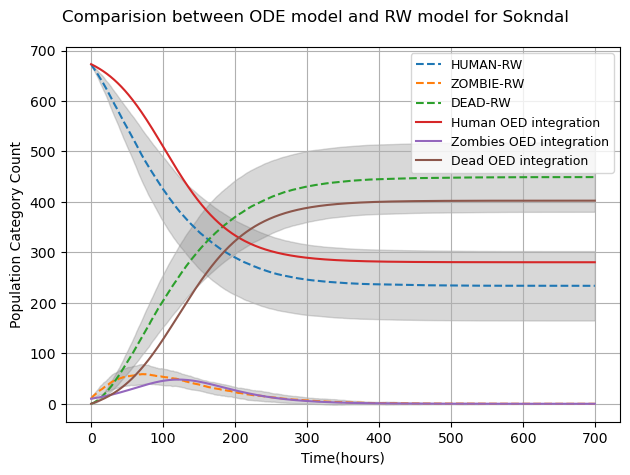

In [39]:
fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df, cats=['HUMAN', 'ZOMBIE', 'DEAD'])

ax.plot(t_ode, S_ode,'-', label='Human OED integration')
ax.plot(t_ode, Z_ode,'-', label='Zombies OED integration')
ax.plot(t_ode, D_ode,'-', label='Dead OED integration')


ax.legend(fontsize=9)
fig.suptitle(f'Comparision between ODE model and RW model for {place}')
ax.set(xlabel='Time(hours)', ylabel='Population Category Count')
plt.tight_layout()

## Question 2: For future zombie attacks: What is approximately the highest life expectancy of zombies, where humans still survive?

In [83]:
humans_left = []
zombies_left = []
zle = range(20,100,5)
for zomb_life_exp in zle:
    params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/zomb_life_exp,'nx':50, 'ny':50, 'T':500}
    samples = 100
    mcmodel=MCRW(samples=samples)
    _ = mcmodel.run_mc(**params)
    a = mcmodel.averaged_mc_df
    humans_left.append(a['HUMAN','mean'].to_numpy()[-1])
    zombies_left.append(a['ZOMBIE','mean'].to_numpy()[-1])
    #print(f'zombie life expectancy {zomb_life_exp}\n', a.loc[a.index[-1]])
    #plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df, cats=['HUMAN', 'ZOMBIE', 'DEAD'], show_band=False)


In [85]:
%matplotlib notebook

<IPython.core.display.Javascript object>


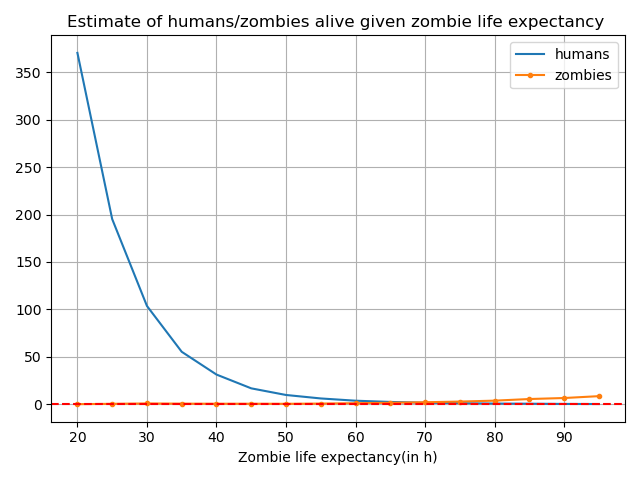

In [86]:
fig, ax = plt.subplots()
ax.plot(zle,humans_left, label= 'humans')
ax.plot(zle,zombies_left,'.-', label= 'zombies')
ax.set(title='Estimate of humans/zombies alive given zombie life expectancy ', xlabel='Zombie life expectancy(in h)')
ax.grid()
ax.axhline(0, linestyle = '--', color= 'r')
ax.legend()
plt.tight_layout()

In [90]:
np.interp(1, zombies_left, zle), np.interp(-0.5, zombies_left, zle)

(59.63414634146341, 20.0)

**Discussion** :Humans survive if there is at least one human present and less than 1 zombie
We ran a sensitivity analysis for number of zombie and humans left for various 'Zombie life expectancy'.

for zombie life expectancy of 59h less than one zombie survives 


# Create your own scenario

Scene ideas:
1. fast zombies (zombies move twice and infect)
2. or one idea from the proposed.
3. ...


In [64]:
a = mcmodel.averaged_mc_df.copy()
print(a.loc[a.index[-1]])

HUMAN   mean     10.000000
        std       7.314369
ZOMBIE  mean      0.400000
        std       0.894427
CURED   mean      0.000000
        std       0.000000
DEAD    mean    672.600000
        std       7.092249
Name: 500, dtype: float64


sim_time  HUMAN           ZOMBIE           CURED        DEAD          
               mean       std   mean       std  mean  std   mean       std
0          0  673.0  0.000000   10.0  0.000000   0.0  0.0    0.0  0.000000
1          1  671.8  1.095445   11.2  1.095445   0.0  0.0    0.0  0.000000
2          2  671.0  1.000000   11.4  0.894427   0.0  0.0    0.6  0.547723
3          3  669.4  1.816590   13.0  1.414214   0.0  0.0    0.6  0.547723
4          4  667.6  2.073644   14.0  2.000000   0.0  0.0    1.4  1.341641
..       ...    ...       ...    ...       ...   ...  ...    ...       ...
496      496   10.0  7.314369    0.4  0.894427   0.0  0.0  672.6  7.092249
497      497   10.0  7.314369    0.4  0.894427   0.0  0.0  672.6  7.092249
498      498   10.0  7.314369    0.4  0.894427   0.0  0.0  672.6  7.092249
499      499   10.0  7.314369    0.4  0.894427   0.0  0.0  672.6  7.092249
500      500   10.0  7.314369    0.4  0.894427   0.0  0.0  672.6  7.092249

[501 rows x 9 columns]

In [27]:
crap

NameError: name 'crap' is not defined

In [ ]:

place = 'Sokndal'
zomb_life_exp = 24
params = {'population': 683, 'infected': 10, 'q': 0.9,
          'dp': 1/zomb_life_exp, 'nx': 50, 'ny': 50, 'T': 700}
samples = 100
mcmodel = MCRW(samples=samples)
mcmodel.run_mc(**params)

fig, ax = plt.subplots()
plot_mc_results(ax=ax, mc_averaged_data=mcmodel.averaged_mc_df,
                cats=['HUMAN', 'ZOMBIE', 'DEAD'])
ax.set(title=f'Zombie apocalypse in {place}',
       xlabel='Time(hours)', ylabel='Population Category Count')

In [ ]:
# Sokndal
#
place = 'Sokndal'
zomb_life_exp = 24
params = {'population': 683, 'infected': 10, 'q': 0.9,
          'dp': 1/zomb_life_exp, 'nx': 50, 'ny': 50, 'T': 400}
samples = 200
mcmodel = MCRW(samples=samples)
mcmodel.run_mc(**params)

fig, ax = plt.subplots()
plot_mc_results(ax=ax, mc_averaged_data=mcmodel.averaged_mc_df,
                cats=['HUMAN', 'ZOMBIE', 'DEAD'])
ax.set(title=f'Zombie apocalypse in {place}',
       xlabel='Time(hours)', ylabel='Population Category Count')

In [ ]:
C = mcmodel.modelresults_df.avg_interactions.mean()
q = params['q']
beta = C*q
tau=1/zomb_life_exp

In [ ]:
a = BucketModel(Z0=10,beta=beta,dp=tau, size = 200)
a.ODE_SZ_model()

In [ ]:
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 1/24,'nx':50, 'ny':50, 'T':700}
samples = 100
mcmodel=MCRW(samples=samples)
mcmodel.run_mc(**params)

fig, ax = plt.subplots()
plot_mc_results(ax = ax, mc_averaged_data=mcmodel.averaged_mc_df,cats=['HUMAN', 'ZOMBIE', 'DEAD'])


In [ ]:
np.where (1/np.array(taus)!=0)[0]

In [ ]:
1/np.array(taus)!=0

In [ ]:
df

In [ ]:
a=[1,2,3,np.nan, np.inf]

In [ ]:
np.nanmean(a)

In [ ]:
params = {'population':683, 'infected':10, 'q':0.9, 'dp': 0.5,'nx':50, 'ny':50, 'T':300}
samples = 100
mcmodel=MCRW(samples=samples)
mcmodel.run_mc(**params)

In [ ]:
_

In [ ]:
if 
    np.sum(np.random.rand(10)<0)

In [ ]:
mcmodel.averaged_mc_df

In [ ]:
crap

# TODO
1. fix seed

In [ ]:
def calc_no_of_interactions(x,y):
    a = np.array([x,y]).T
    uniques, counts = np.unique(a, return_counts=True, axis = 0)
    #print(uniques,counts)
    
    more_than_one = counts>1
    counts = counts[more_than_one]
    # if n agents are presnt at a location, number of interactions
    # nc2 =n*(n-1)
    interactions = np.sum(counts*(counts-1)) 
    return(interactions)

In [ ]:
params = {'population':683, 'infected':10, 'q':0.9, 'nx':50, 'ny':50, 'T':180}
samples = 100
mcmodel=MCRW(samples=samples)
mcmodel.run_mc(**params)
df = mcmodel.mcresults_df

In [ ]:
df = mcmodel.modelresults_df.copy()
xlocs, ylocs  = df.xlocs.to_numpy(), df.ylocs.to_numpy()
interactions = []
for x,y in zip(xlocs, ylocs):
    interactions.append(calc_no_of_interactions(x, y))
interactions = np.array(interactions) 
df['avg_interactions']= interactions/params['population']

In [ ]:
df.head()

In [ ]:
by_sim_no = df.groupby('sim_no')
fig, axs = plt.subplots(nrows = 2)
ax = axs[0]
for sim, sim_df in by_sim_no:
    sim_df['avg_interactions'].plot(ax = ax)

ax = axs[1]
ax.hist(df.avg_interactions, bins = 25)

fig.suptitle('Is number of interactions')
plt.tight_layout()
df[['avg_interactions']].describe()

In [ ]:
df.avg_interactions

In [ ]:
%%timeit
a=[]
for i in range(100000):
    a.append(i)

In [ ]:
%%timeit
a =[i for i in range(100000)]

In [ ]:
def calculate_beta(df):
    
    '''receives a df with number of Human/zombies/cured etc at each time stamp and returns βΔt'''
    #print(df)
    N = df.sum(axis = 1)[0]
    S = df.HUMAN.to_numpy()
    Z = df.ZOMBIE[1:].to_numpy()
    #print(N, len(S), len(Z))
    beta = -(S[1:]-S[:-1])*N/(S[1:]*Z)
    return(beta)
    
def calculate_beta_matrix(df):
    '''
    receives the dataframe of simulation results 
    returns a array of shape(sim,timestamps) of βΔt values
    '''
    b = df.groupby('sim_no')
    betas = []
    for i in b.groups:
        df = b.get_group(i)
        df = df[df.columns[:-2]]
        beta = calculate_beta(df)
        betas.append(beta)
        #print(beta)
    betas = np.array(betas)
    print(betas.shape, ':( rows = sim_numbers, cols = timesteps)')
    return(betas)

def calc_beta_from_interactions(modelresults_df,q):
    xlocsarr = modelresults_df['xlocs'].to_numpy()
    ylocsarr = modelresults_df['ylocs'].to_numpy()
    N = len(xlocsarr[0])
    avg_interactions = []
    for xlocs,ylocs in zip(xlocsarr,ylocsarr):
        locs = np.array([xlocs,ylocs]).T
        locs = SZR.to_tuple(locs)
        uniques , counts = np.unique(locs, return_counts=True, axis= 0)
        a = counts>1
        #print(uniques[a], counts[a])
        interactions = counts[a]*(counts[a]-1)
        #print(counts[a],interactions, interactions.sum(),N)
        avg_interactions.append(interactions.sum()/N)
    #print(ylocsarr)
    df_ = modelresults_df[['time','sim_no']].copy()
    df_['beta_interactions'] = np.array(avg_interactions)*q
    df_ = df_.groupby('time')[['beta_interactions']].agg('mean')
    beta_interactions = df_.beta_interactions.to_numpy()[1:]
    return(beta_interactions)

In [ ]:
betas

In [ ]:
beta_t= betas.mean(axis=0)
t = np.arange(params['T']+1)
soln = ODE_SZ_model(t,beta_t,N = params['population'],Z0 = params['infected'])
ODE_H, ODE_Z = soln[:,0], soln[:,1]

In [ ]:
modelresults_df = mcmodel.modelresults_df
beta_interactions = calc_beta_from_interactions(modelresults_df, params['q'])
soln = ODE_SZ_model(t,beta_interactions,N = params['population'],Z0 = params['infected'])
ODEI_H, ODEI_Z = soln[:,0], soln[:,1]

In [ ]:
fig,ax = plt.subplots()
plot_mc_results(ax,mcmodel.averaged_mc_df)
ax.plot(ana_t,ana_H, label='ANA_HUMAN')
ax.plot(ana_t,ana_Z, label='ANA_ZOMBIE')
ax.plot(t,ODE_H, label='ODE_HUMAN')
ax.plot(t,ODE_Z, label='ODE_ZOMBIE')
#ax.plot(t,ODEI_H, label='ODEI_HUMAN')
#ax.plot(t,ODEI_Z, label='ODEI_ZOMBIE')
ax.legend()

Now that we have a matrix of $\beta \Delta t$ for each of the monte carlo simulation we can estimate $\beta \Delta t$ by two methods 
1. by averaging $\beta \Delta t$ over all values of $\beta \Delta t$
2. time dependent $\beta \Delta t$

we can also calculate $\beta \Delta t$ ab initio ie. by finding how many interactions occure during each time step and averaging it over 

In [ ]:
betas.mean(axis = 0),betas.mean()

In [ ]:
integrate.odeint()

In [ ]:
def G(u, v, f, k):
    return f * (1 - u) - u*v**2

def H(u, v, f, k):
    return -(f + k) * v + u*v**2

In [ ]:
def grayscott1d(y, t, f, k, Du, Dv, dx):
    """
    Differential equations for the 1-D Gray-Scott equations.

    The ODEs are derived using the method of lines.
    """
    # The vectors u and v are interleaved in y.  We define
    # views of u and v by slicing y.
    u = y[::2]
    v = y[1::2]

    # dydt is the return value of this function.
    dydt = np.empty_like(y)

    # Just like u and v are views of the interleaved vectors
    # in y, dudt and dvdt are views of the interleaved output
    # vectors in dydt.
    dudt = dydt[::2]
    dvdt = dydt[1::2]

    # Compute du/dt and dv/dt.  The end points and the interior points
    # are handled separately.
    dudt[0]    = G(u[0],    v[0],    f, k) + Du * (-2.0*u[0] + 2.0*u[1]) / dx**2
    dudt[1:-1] = G(u[1:-1], v[1:-1], f, k) + Du * np.diff(u,2) / dx**2
    dudt[-1]   = G(u[-1],   v[-1],   f, k) + Du * (- 2.0*u[-1] + 2.0*u[-2]) / dx**2
    dvdt[0]    = H(u[0],    v[0],    f, k) + Dv * (-2.0*v[0] + 2.0*v[1]) / dx**2
    dvdt[1:-1] = H(u[1:-1], v[1:-1], f, k) + Dv * np.diff(v,2) / dx**2
    dvdt[-1]   = H(u[-1],   v[-1],   f, k) + Dv * (-2.0*v[-1] + 2.0*v[-2]) / dx**2

    return dydt

In [ ]:
rng = np.random.default_rng()

y0 = rng.standard_normal(5000)

t = np.linspace(0, 50, 11)

f = 0.024

k = 0.055

Du = 0.01

Dv = 0.005

dx = 0.025

In [ ]:
a =odeint(grayscott1d, y0, t, args=(f, k, Du, Dv, dx))

In [ ]:
y0,t

In [ ]:
y0.shape ,t.shape , a.shape

In [ ]:
a

In [ ]:
from scipy.integrate import odeint

ODE 